In [15]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import scienceplots
from cmap import Colormap

In [16]:
cmap = Colormap("seaborn:mako").to_mpl()

In [17]:
h = 1
mu = 1e-3
G = 1e-3
def velocity_field(x, y):
    return G / (2 * mu) * (h**2 - y**2)

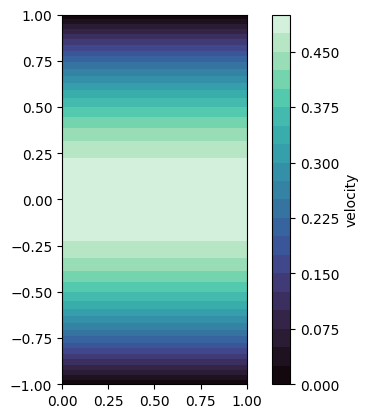

In [18]:
x_mesh = jnp.linspace(0, 1)
y_mesh = jnp.linspace(-1, 1)
X, Y = jnp.meshgrid(x_mesh, y_mesh)
V = velocity_field(X, Y)

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
im = ax.contourf(X, Y, V, levels=20, cmap=cmap)
fig.colorbar(im, ax=ax, label='velocity')

In [19]:
N_COLLOCATION_POINTS = 100
N_DATA_POINTS = 3
N_BC_POINTS = 2

LEARNING_RATE = 0.001
N_OPTIMIZATION_EPOCHS = 20000

BC_LOSS_WEIGHT = 500.0 / N_BC_POINTS
DATA_LOSS_WEIGHT = 500.0 / N_DATA_POINTS

In [20]:
key = jr.PRNGKey(42)

In [21]:
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size="scalar",
    out_size="scalar",
    width_size=10,
    depth=5,
    activation=jax.nn.sigmoid,
    key=key,
)

In [22]:
def pde_residuum(network, x):
    return jax.grad(jax.grad(network))(x)

In [23]:
def data_residuum(network, x):
    return network(x) - velocity_field(0, x)

In [24]:
key, coll_sampling_key = jr.split(key)
collocation_points = jr.uniform(coll_sampling_key, (N_COLLOCATION_POINTS, ), minval=-1.0 + 1e-2, maxval=1.0 - 1e-2)

# key, data_sampling_key = jr.split(key)
data_points = jnp.array([0.0, 0.5, -0.5])

def loss_fn(network):
    pde_res_coll = jax.vmap(pde_residuum, in_axes=(None, 0))(network, collocation_points)
    pde_loss = jnp.mean(jnp.square(pde_res_coll))
    
    left_bc_res = network(-1.0) - 0.0
    right_bc_res = network(1.0) - 0.0
    bc_loss = jnp.mean(jnp.square(left_bc_res)) + jnp.mean(jnp.square(right_bc_res))

    data_res = jax.vmap(data_residuum, in_axes=(None, 0))(network, data_points)
    data_loss = jnp.mean(jnp.square(data_res))
    
    total_loss = 0.5 * (pde_loss + BC_LOSS_WEIGHT * bc_loss + DATA_LOSS_WEIGHT * data_loss)
    
    return total_loss

In [25]:
loss_fn(pinn)

Array(11.1854315, dtype=float32)

In [26]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

loss_history = np.zeros(N_OPTIMIZATION_EPOCHS)

for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history[epoch] = loss
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 11.185431480407715
Epoch: 100, loss: 11.139760971069336
Epoch: 200, loss: 11.137886047363281
Epoch: 300, loss: 11.09652328491211
Epoch: 400, loss: 10.039813995361328
Epoch: 500, loss: 7.417165279388428
Epoch: 600, loss: 0.49600908160209656
Epoch: 700, loss: 0.41547077894210815
Epoch: 800, loss: 0.3891848623752594
Epoch: 900, loss: 0.3793860971927643
Epoch: 1000, loss: 0.3753046691417694
Epoch: 1100, loss: 0.3741507828235626
Epoch: 1200, loss: 0.373250275850296
Epoch: 1300, loss: 0.37382951378822327
Epoch: 1400, loss: 0.3728675842285156
Epoch: 1500, loss: 0.3731936514377594
Epoch: 1600, loss: 0.37270763516426086
Epoch: 1700, loss: 0.37292835116386414
Epoch: 1800, loss: 0.37258315086364746
Epoch: 1900, loss: 0.37270525097846985
Epoch: 2000, loss: 0.3724713921546936
Epoch: 2100, loss: 0.3727170526981354
Epoch: 2200, loss: 0.3723703622817993
Epoch: 2300, loss: 0.37268558144569397
Epoch: 2400, loss: 0.3722791373729706
Epoch: 2500, loss: 0.3722442090511322
Epoch: 2600, loss: 

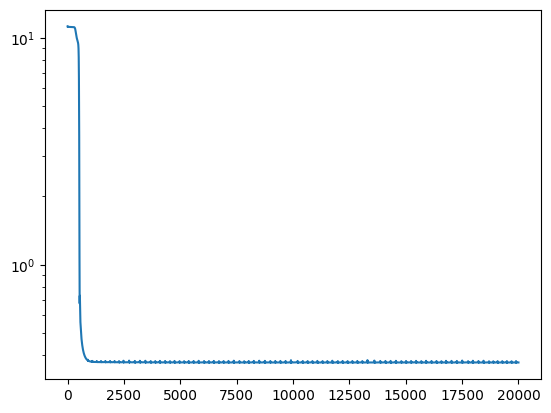

In [27]:
plt.plot(loss_history)
plt.yscale("log")

Text(0.5, 1.0, 'PINN sol')

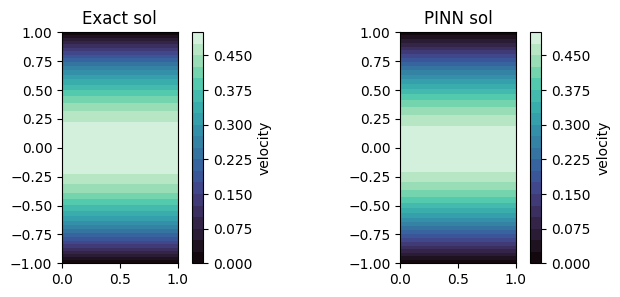

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

x_mesh = jnp.linspace(0, 1)
y_mesh = jnp.linspace(-1, 1)
X, Y = jnp.meshgrid(x_mesh, y_mesh)
V = velocity_field(X, Y)
im1 = ax1.contourf(X, Y, V, levels=20, cmap=cmap)
fig.colorbar(im1, ax=ax1, label='velocity')
ax1.set_title("Exact sol")

VY_PINN = jax.vmap(pinn)(y_mesh)
V_PINN = np.tile(VY_PINN, (X.shape[1], 1)).T
im2 = ax2.contourf(X, Y, V_PINN, levels=20, cmap=cmap)
fig.colorbar(im2, ax=ax2, label='velocity')
ax2.set_title("PINN sol")